# Elmo

## Import Packages

In [ ]:
!pip install tensorflow==2.3
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==2.3

     |████████████████████████████████| 2.6MB 5.2MB/s 


In [ ]:
#Load packages
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn import metrics, preprocessing,model_selection 
from sklearn.metrics import accuracy_score 
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense 
from tensorflow.keras.models import Model 
import tensorflow.keras.backend as K 
import matplotlib.pyplot as pit 
import seaborn as sns
import numpy as np 
import string 
import pandas as pd 
import re 
import spacy 
from nltk.corpus import stopwords 
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS 
from spacy.lang.en import English 
spacy.load('en') 
parser = English()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
K= tf.compat.v1.keras.backend.get_session()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##load Elmo

In [ ]:
# get elmo from tensorflow hub 
import tensorflow_hub as hub 
import tensorflow as tf 

embed = hub.load('https://tfhub.dev/google/nnlm-en-dim128/1')
embed.signatures['default'](tf.convert_to_tensor(['my text', 'batch']))

{'default': <tf.Tensor: shape=(2, 128), dtype=float32, numpy=
 array([[ 0.06817301,  0.12772666,  0.04918525, -0.03550394, -0.04533052,
          0.04868454,  0.00771219, -0.02631581, -0.16468817,  0.1887698 ,
          0.01009648, -0.18591057,  0.05160484,  0.13291915,  0.01235215,
         -0.00492161, -0.06701647, -0.01161232, -0.01099506,  0.21438217,
          0.04877856, -0.10143851, -0.12461483, -0.00835736, -0.01975276,
         -0.0518438 ,  0.0135941 ,  0.04147662, -0.14309719, -0.10322613,
         -0.08090361, -0.01536523, -0.11944003, -0.04822929,  0.13167971,
         -0.06830869, -0.04490855,  0.03839394,  0.0882614 ,  0.01578063,
         -0.16467947, -0.09377561,  0.01380978, -0.04058216,  0.03929568,
          0.09588426, -0.15572111, -0.15270787, -0.04349912, -0.0844278 ,
          0.00472539,  0.01002582,  0.03455054,  0.0139303 , -0.11444485,
         -0.07043104,  0.03757556, -0.00822732,  0.07750841, -0.02362585,
          0.11321948, -0.02998928,  0.19748685,  0

## Pre-process Data

In [ ]:
# Stop words and special characters 
import nltk 
nltk.download('stopwords') 

STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-","...","”","''"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Data Cleaner and tokenizer 
def tokenizeText(text): 
  text = text.strip().replace("\n", " ").replace("\r", " ") 
  text = text.lower() 
  
  tokens = parser(text) 
  #lematization
  lemmas = [] 
  for tok in tokens:
     lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
  tokens = lemmas 
  #reomve stop words and special charaters 
  tokens = [tok for tok in tokens if tok.lower() not in STOPLIST] 
  tokens = [tok for tok in tokens if tok not in SYMBOLS] 
  
  tokens = [tok for tok in tokens if len(tok) >= 3]
  
  #remove remaining tokens that are not alphabetic 
  tokens = [tok for tok in tokens if tok.isalpha()] 
  
  tokens = list(set(tokens)) 
  
  return ' '.join(tokens[:]) 

In [ ]:
def encode(le_enc, labels): 
  enc = le_enc.transform(labels) 
  return keras.utils.to_categorical(enc) 

def decode(le_enc, one_hot):
   dec = np.argmax(one_hot, axis =1) 
   return le_enc.inverse_transform(dec) 

In [ ]:
# load the dataset 
import pandas as pd
trainDF_Sheet_1 = pd.read_csv("/content/drive/My Drive/data/data_train.csv")

In [ ]:
trainDF_Sheet_1.head(2) 

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0


In [ ]:
trainDF_Sheet_1.shape 

(515738, 2)

In [ ]:
trainDF_Sheet_1['review'].unique() 

array([' I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to 

In [ ]:
trainDF_Sheet_1['review'].value_counts() 

No Negative Location                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       1009
 Nothing Everything                                                                                                                                                                                                                                                                                                                                     

In [ ]:
# model parameters

vocab_size = 1000
embedding_dim = 256
max_length = 512
trunc_type='post'
padding_type='post'
oov_tok = "<00V>"
training_portion = .7

In [ ]:
# train test split
# ---------- 
              
# proportion of training dataset
train_size = int(trainDF_Sheet_1.shape[0] * training_portion)

# training dataset
train_sentences = trainDF_Sheet_1['review'][:train_size]
train_labels = trainDF_Sheet_1['is_bad_review'][:train_size]

# validation dataset
validation_sentences = trainDF_Sheet_1['review'][train_size: ]
validation_labels = trainDF_Sheet_1['is_bad_review'][train_size: ]

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
def padd(sentence):
    arr=word_tokenize(sentence)
    for i in range(1000-len(arr)):
        arr.append('null')
    return arr[:1000]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
y_test = trainDF_Sheet_1["is_bad_review"]
train_sentences = trainDF_Sheet_1["review"]
train_data=[padd(each_sentence) for each_sentence in train_sentences[:1000]]

In [ ]:
# for i in range(0,len(train_sentences),10000):
training_embed=([embed.signatures['default'](tf.convert_to_tensor(each_sentence))['default'] for each_sentence in train_data])

In [ ]:
len(training_embed[0][0])

128

## With cnn

In [ ]:

#   return model
model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(128, 5, activation='relu'),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dense(24, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy', optimizer='adam',
   metrics=['accuracy'])
model.build(input_shape=[len(training_embed),1000,128])

# model summary
model.summary ()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (1000, 996, 128)          82048     
_________________________________________________________________
global_max_pooling1d (Global (1000, 128)               0         
_________________________________________________________________
dense (Dense)                (1000, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (1000, 1)                 25        
Total params: 85,169
Trainable params: 85,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:

num_epochs = 10

history = model.fit(np.array(training_embed), np.array(y_test[:1000]),
   epochs=num_epochs,verbose=1)

model.save_weights('./response-elmo-model.h5')

Epoch 1/10
32/32 [==============================] - 8s 236ms/step - loss: 0.2827 - accuracy: 0.9190
Epoch 2/10
32/32 [==============================] - 7s 231ms/step - loss: 0.1801 - accuracy: 0.9520
Epoch 3/10
32/32 [==============================] - 7s 231ms/step - loss: 0.1726 - accuracy: 0.9520
Epoch 4/10
32/32 [==============================] - 7s 231ms/step - loss: 0.1545 - accuracy: 0.9520
Epoch 5/10
32/32 [==============================] - 7s 232ms/step - loss: 0.1331 - accuracy: 0.9520
Epoch 6/10
32/32 [==============================] - 7s 233ms/step - loss: 0.1071 - accuracy: 0.9520
Epoch 7/10
32/32 [==============================] - 7s 234ms/step - loss: 0.0804 - accuracy: 0.9530
Epoch 8/10
32/32 [==============================] - 7s 234ms/step - loss: 0.0549 - accuracy: 0.9760
Epoch 9/10
32/32 [==============================] - 8s 236ms/step - loss: 0.0337 - accuracy: 0.9940
Epoch 10/10
32/32 [==============================] - 7s 234ms/step - loss: 0.0202 - accuracy: 0.9990

In [ ]:
print(history.history)

{'loss': [0.2827097475528717, 0.18007420003414154, 0.1725819706916809, 0.15453478693962097, 0.1330624222755432, 0.10710322856903076, 0.08044683188199997, 0.05485148727893829, 0.033730436116456985, 0.020218733698129654], 'accuracy': [0.9190000295639038, 0.9520000219345093, 0.9520000219345093, 0.9520000219345093, 0.9520000219345093, 0.9520000219345093, 0.953000009059906, 0.9760000109672546, 0.9940000176429749, 0.9990000128746033]}


**Predicting output from model**

In [ ]:
# # # tokenizing, sequencing, padding features        
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
y_test = trainDF_Sheet_1["is_bad_review"]
train_sentences = trainDF_Sheet_1["review"]

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
train_data=tokenizer.sequences_to_texts(train_padded)

In [ ]:
#print(train_padded)
prediction = model.predict(np.array(training_embed))

In [ ]:
y_pred = (prediction > 0.5)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
y_test = (y_test[:1000])

1000
1000


**Calculating Precision , Recall ,Accuracy ,Confusion Matrix and Graph**

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score
print("F1-score: {0}".format(f1_score(y_pred, y_test)))
print("Precision: ",precision_score(y_pred, y_test))
print("Recall: ",recall_score(y_pred, y_test))
print("Accuracy: ",accuracy_score(y_pred,y_test))
print("Confusion matrix: ")
confusion_matrix(y_pred, y_test)

F1-score: 0.9894736842105264
Precision:  0.9791666666666666
Recall:  1.0
Accuracy:  0.999
Confusion matrix: 


array([[952,   1],
       [  0,  47]])

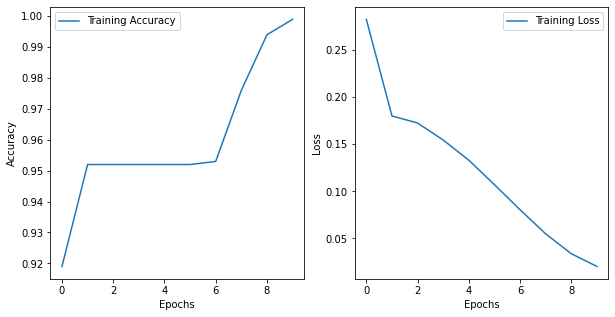

In [ ]:
 # accuracy and loss
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()

plt.show()

## With RNN

In [ ]:
# model initialization
model = tf.keras.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
  tf.keras.layers.Dense(24, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid' )
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.build(input_shape=[len(training_embed),1000,128])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (1000, 200)               183200    
_________________________________________________________________
dense (Dense)                (1000, 24)                4824      
_________________________________________________________________
dense_1 (Dense)              (1000, 1)                 25        
Total params: 188,049
Trainable params: 188,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 8

history = model.fit(np.array(training_embed), np.array(y_test[:1000]),
   epochs=num_epochs,verbose=1)

model.save_weights('/content/drive/My Drive/response-rnn-elmo-model.h5')

Epoch 1/8
32/32 [==============================] - 3s 78ms/step - loss: 0.2835 - accuracy: 0.9380
Epoch 2/8
32/32 [==============================] - 2s 74ms/step - loss: 0.1905 - accuracy: 0.9520
Epoch 3/8
32/32 [==============================] - 2s 75ms/step - loss: 0.1862 - accuracy: 0.9520
Epoch 4/8
32/32 [==============================] - 2s 76ms/step - loss: 0.1810 - accuracy: 0.9520
Epoch 5/8
32/32 [==============================] - 2s 75ms/step - loss: 0.1750 - accuracy: 0.9520
Epoch 6/8
32/32 [==============================] - 2s 76ms/step - loss: 0.1580 - accuracy: 0.9520
Epoch 7/8
32/32 [==============================] - 2s 76ms/step - loss: 0.1418 - accuracy: 0.9510
Epoch 8/8
32/32 [==============================] - 2s 74ms/step - loss: 0.1260 - accuracy: 0.9540


In [ ]:
model.load_weights('/content/drive/My Drive/response-rnn-elmo-model.h5')

In [ ]:
y_test = (y_test[:1000])

In [ ]:
prediction = model.predict(np.array(training_embed))

In [ ]:
y_pred = (prediction > 0.5)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score
print("F1-score: {0}".format(f1_score(y_pred, y_test)))
print("Precision: ",precision_score(y_pred, y_test))
print("Recall: ",recall_score(y_pred, y_test))
print("Accuracy: ",accuracy_score(y_pred,y_test))
print("Confusion matrix: ")
confusion_matrix(y_pred, y_test)

F1-score: 0.07999999999999999
Precision:  0.041666666666666664
Recall:  1.0
Accuracy:  0.954
Confusion matrix: 


array([[952,  46],
       [  0,   2]])

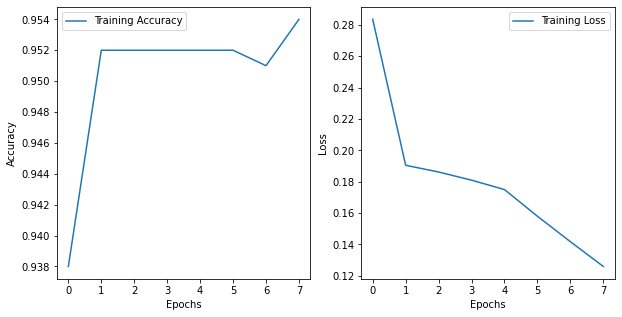

In [ ]:
 # accuracy and loss
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()

plt.show()